Once we've trained a model, we might want to better understand what sequence motifs the first convolutional layer has discovered and how it's using them. Basset offers two methods to help users explore these filters.

You'll want to double check that you have the Tomtom motif comparison tool for the MEME suite installed. Tomtom provides rigorous methods to compare the filters to a database of motifs. You can download it from here: http://meme-suite.org/doc/download.html

To run this tutorial, you'll need to either download the pre-trained model from https://www.dropbox.com/s/rguytuztemctkf8/pretrained_model.th.gz and preprocess the consortium data, or just substitute your own files here:

In [8]:
model_file = '../data/models/pretrained_model.th'
seqs_file = '../data/encode_roadmap.h5'

First, we'll run basset_motifs.py, which will extract a bunch of basic information about the first layer filters. The script takes an HDF file (such as any preprocessed with preprocess_features.py) and samples sequences from the test set. It sends those sequences through the neural network and examines its hidden unit values to describe what they're doing.

* -m specifies the Tomtom motif database: CIS-BP Homo sapiens database by default.
* -s specifies the number of sequences to sample. 1000 is fast and sufficient.
* -t asks the script to trim uninformative positions off the filter ends.

In [9]:
import subprocess

cmd = 'basset_motifs.py -s 1000 -t -o motifs_out %s %s' % (model_file, seqs_file)
subprocess.call(cmd, shell=True)

0

Now there's plenty of information output in motifs_out. My favorite way to get started is to open the HTML file output by Tomtom's comparison of the motifs to a database. It displays all of the motifs and their database matches in a neat table.

Before we take a look though, let me describe where these position weight matrices came from. Inside the neural network, the filters are reprsented by real-valued matrices. Here's one:

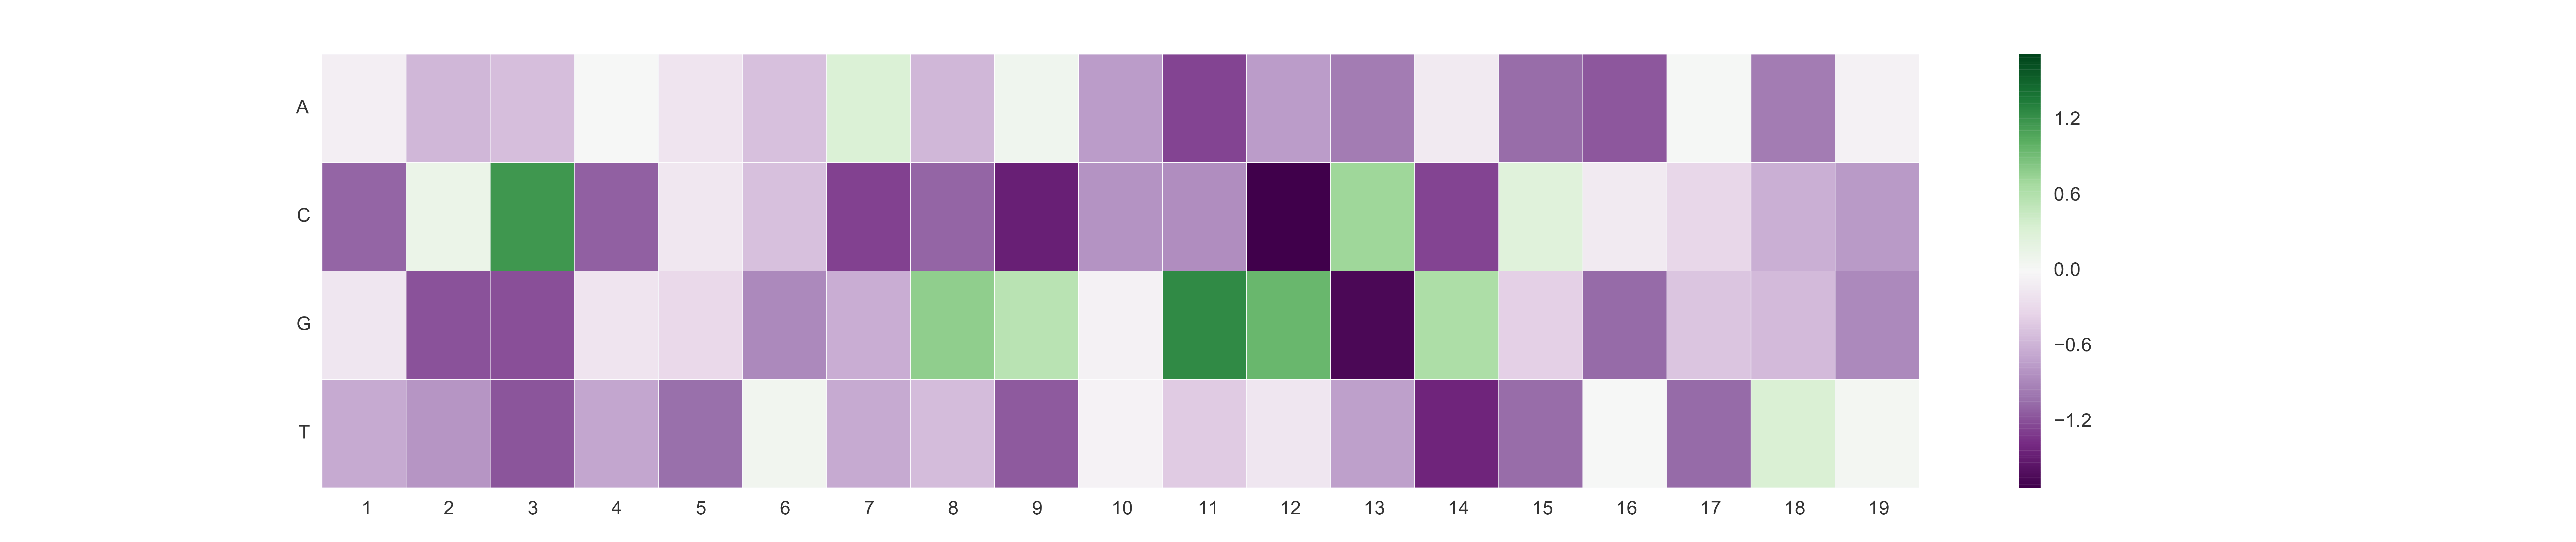

In [10]:
# actual file is motifs_out/filter9_heat.pdf

from IPython.display import Image
Image(filename='motifs_eg/filter9_heat.png') 

Although it's matrix of values, this doesn't quite match up with the conventional notion of a position weight matrix that we typically use to represent sequences motifs in genome biology. To make that, basset_motifs.py pulls out the underlying sequences that activate the filters in the test sequences and passes that to weblogo.

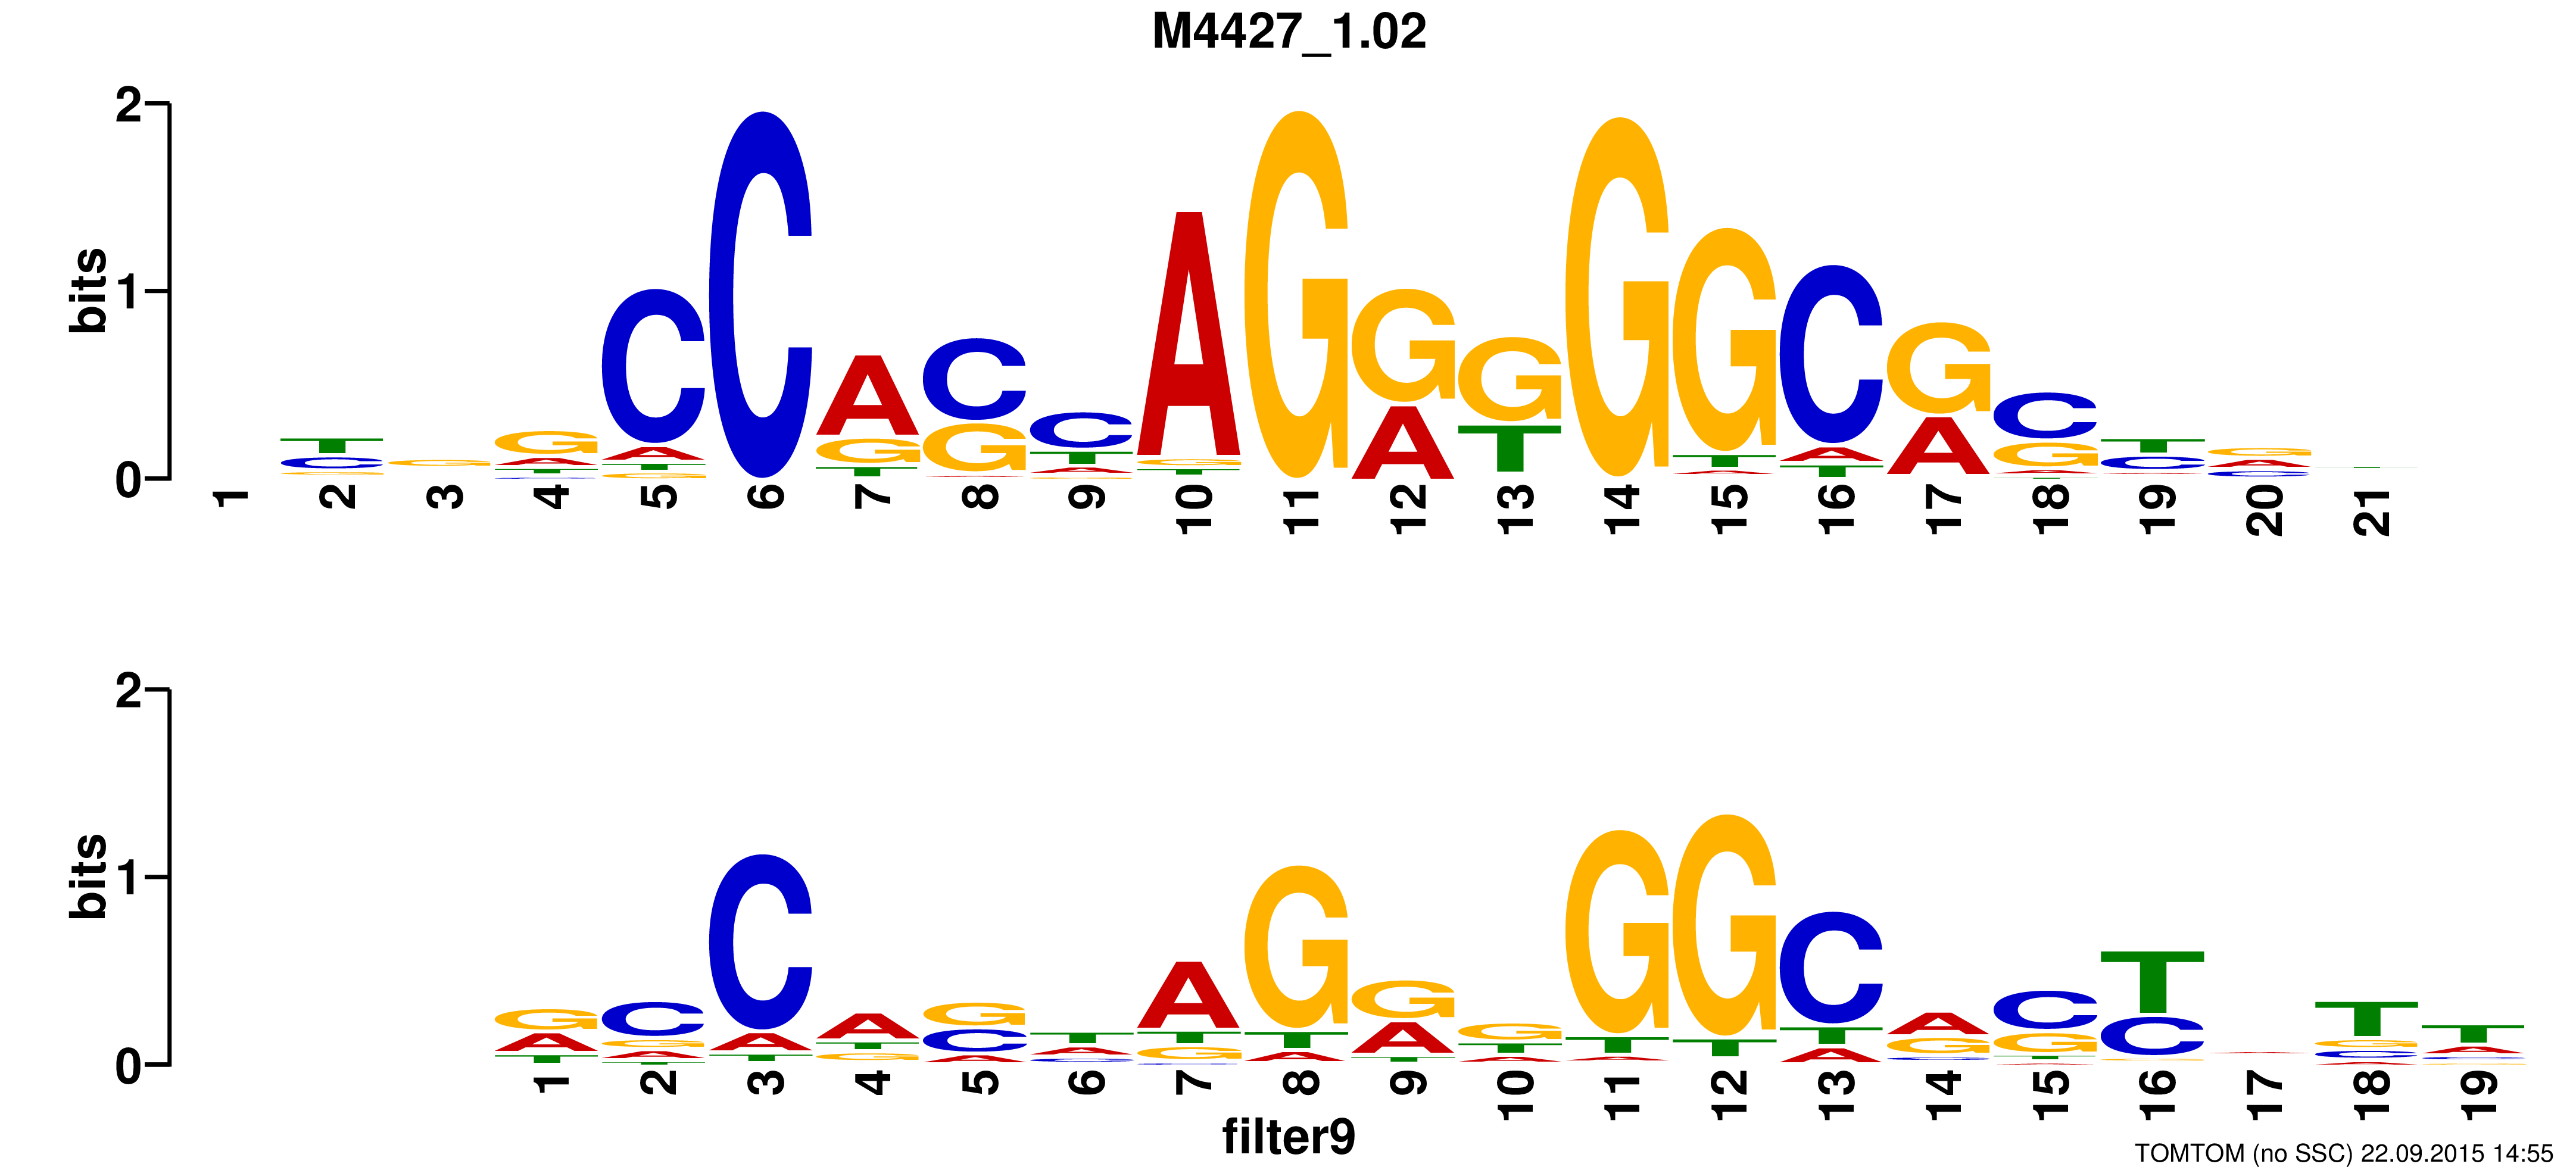

In [11]:
# actual file is motifs_out/filter9_logo.eps

Image(filename='motifs_eg/filter9_logo.png') 

The Tomtom output will annotate the filters, but it won't tell you how the model is using them. So alongside it, let's print out a table of the filters with the greatest output standard deviation over this test set. Variance correlates strongly with how influential the filter is for making predictions.

The columns here are:
1. Index
2. Optimal sequence
3. Tomtom annotation
4. Information content
5. Activation mean
6. Activation standard deviaion

In [12]:
!sort -k6 -gr motifs_out/table.txt | head -n20

118  TCAGGTGGGTATTGTATAC           .   3.86  0.0729  0.0894
88   AAATAGTTAATAATTTTTA      HMG20B   8.63  0.0463  0.0889
208  CATACGTATGTAGTATCAA           .   5.47  0.0332  0.0782
24   TCCGGGCCGCGTATTGCAG           .   4.98  0.0306  0.0743
96   ATAAATGATATTAGCCTGG           .   4.85  0.0467  0.0668
112  TCAATACGACGGGCGTAAA           .   4.92  0.0313  0.0664
219  TTTGGGGGGCGCCACCCGC           .   4.11  0.0322  0.0636
75   TCTCTTGATAATATGATTA           .   6.16  0.0244  0.0625
84   GAATGACTTGGTTGGNTGG           .   6.50  0.0106  0.0594
289  GCCCGATTTTATAACATCA      HOXB13   7.93  0.0099  0.0582
285  ACTTGATCAGGGCTTCTTA      ARID3B   8.19  0.0083  0.0569
171  AATATTGGAATACATGGAC           .   8.38  0.0131  0.0557
105  TTAATTAATTACGTAAAAT  ENSG00000250542   5.62  0.0080  0.0534
19   CGGCCAGTCCGTGGCTAGA           .   5.71  0.0141  0.0505
138  ATATTAATCCAAATGTTTT           .   8.63  0.0059  0.0499
248  CACTATAGCAACTTACTGG           .   5.55  0.0173  0.0496
117  CCCATTGACAAGGCCGTGG           

As I discuss in the paper, unannotated low complexity filters tend to rise to the top here because low order sequence complexity influence accessibility.

The Tomtom output HTML is here:

In [13]:
!open motifs_out/tomtom/tomtom.html

The other primary tool that we have to understand the filters is to remove the filter from the model and assess the impact. Rather than truly remove it and re-train, we can just nullify it within the model by setting all output from the filter to its mean. This way the model around it isn't drastically affected, but there's no information flowing through.

This analysis requires considerably more compute time, so I separated it into a different script. To give it a sufficient number of sequences to obtain a good estimate influence, I typically run it overnight. If your computer is using too much memory, decrease the batch size. I'm going to run here with 1,000 sequences, but I used 20,000 for the paper.

To get really useful output, the script needs a few additional pieces of information:
* -m specifies the table created by basset_motifs.py above.
* -s samples 2000 sequences
* -b sets the batch_size to 500
* -o is the output directory
* --subset limits the cells displayed to those listed in the file.
* -t specifies a table where the second column is the target labels.
* --weight, --height, --font adjust the heatmap

In [18]:
cmd = 'basset_motifs_infl.py'
cmd += ' -m motifs_out/table.txt'
cmd += ' -s 2000 -b 500'
cmd += ' -o infl_out'
cmd += ' --subset motifs_eg/primary_cells.txt'
cmd += ' -t motifs_eg/cell_activity.txt'
cmd += ' --width 7 --height 40 --font 0.5'
cmd += ' %s %s' % (model_file, seqs_file)

subprocess.call(cmd, shell=True)

0